<a href="https://colab.research.google.com/github/ahmedokka29/Network-Intrusion-Detection-System-Using-OneClassSVM/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import SelectKBest, f_classif
import ipaddress
import warnings
warnings.filterwarnings('ignore')

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedelrifai/network-anomaly-detection-dataset")

print("Path to dataset files:", path)
csv_path = path + "/sampled_NF-CSE-CIC-IDS2018-v2.csv"
features_path = path + "/NetFlow_v2_Features.csv"

Path to dataset files: /kaggle/input/network-anomaly-detection-dataset


# 1. Data Loading


In [16]:
# Load the dataset
file_path = csv_path
df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['Label'].value_counts()}")
print(f"\nAttack categories:\n{df['Attack_Category'].value_counts()}")

Dataset shape: (188938, 46)

Class distribution:
Label
0    166356
1     22582
Name: count, dtype: int64

Attack categories:
Attack_Category
Benign          166356
DDoS             13903
DoS               4840
Bot               1431
BruteForce        1209
Infiltration      1164
Web Attacks         35
Name: count, dtype: int64


# 2. Exploratory Data Analysis


Missing values:
0

Numeric features summary:
         L4_SRC_PORT    L4_DST_PORT       PROTOCOL       L7_PROTO  \
count  188938.000000  188938.000000  188938.000000  188938.000000   
mean    52711.328192    1278.669235      10.570669      12.351096   
std     11558.917172    3713.806044       5.444128      28.633257   
min         0.000000       0.000000       1.000000       0.000000   
25%     50745.000000      53.000000       6.000000       0.000000   
50%     54193.000000      80.000000       6.000000       0.000000   
75%     59496.000000     445.000000      17.000000       7.000000   
max     65535.000000   65535.000000      58.000000     245.000000   

           IN_BYTES        IN_PKTS     OUT_BYTES       OUT_PKTS  \
count  1.889380e+05  188938.000000  1.889380e+05  188938.000000   
mean   1.631422e+03      20.691248  6.476994e+03       9.401121   
std    5.894413e+04     982.664898  4.997069e+05     360.612790   
min    2.800000e+01       1.000000  0.000000e+00       0.000000 

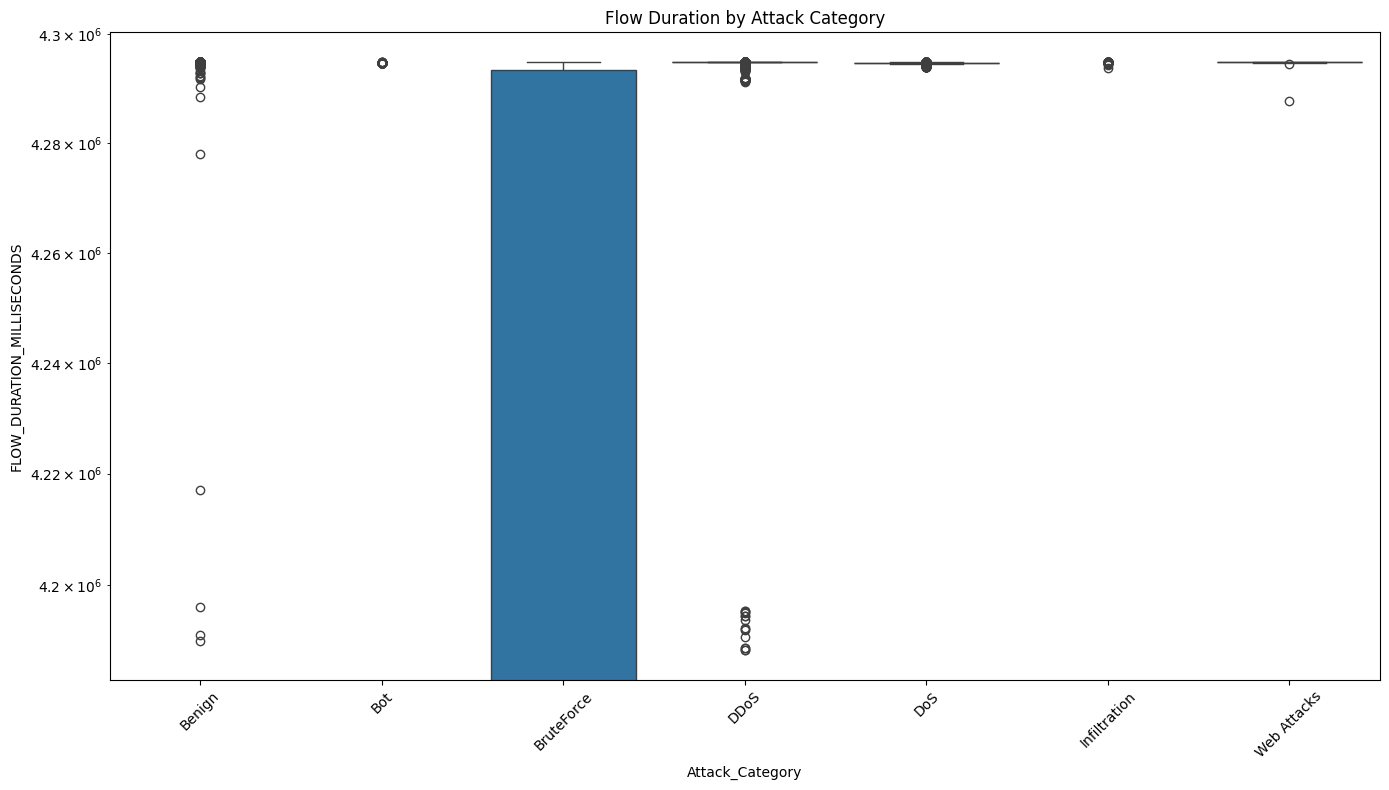

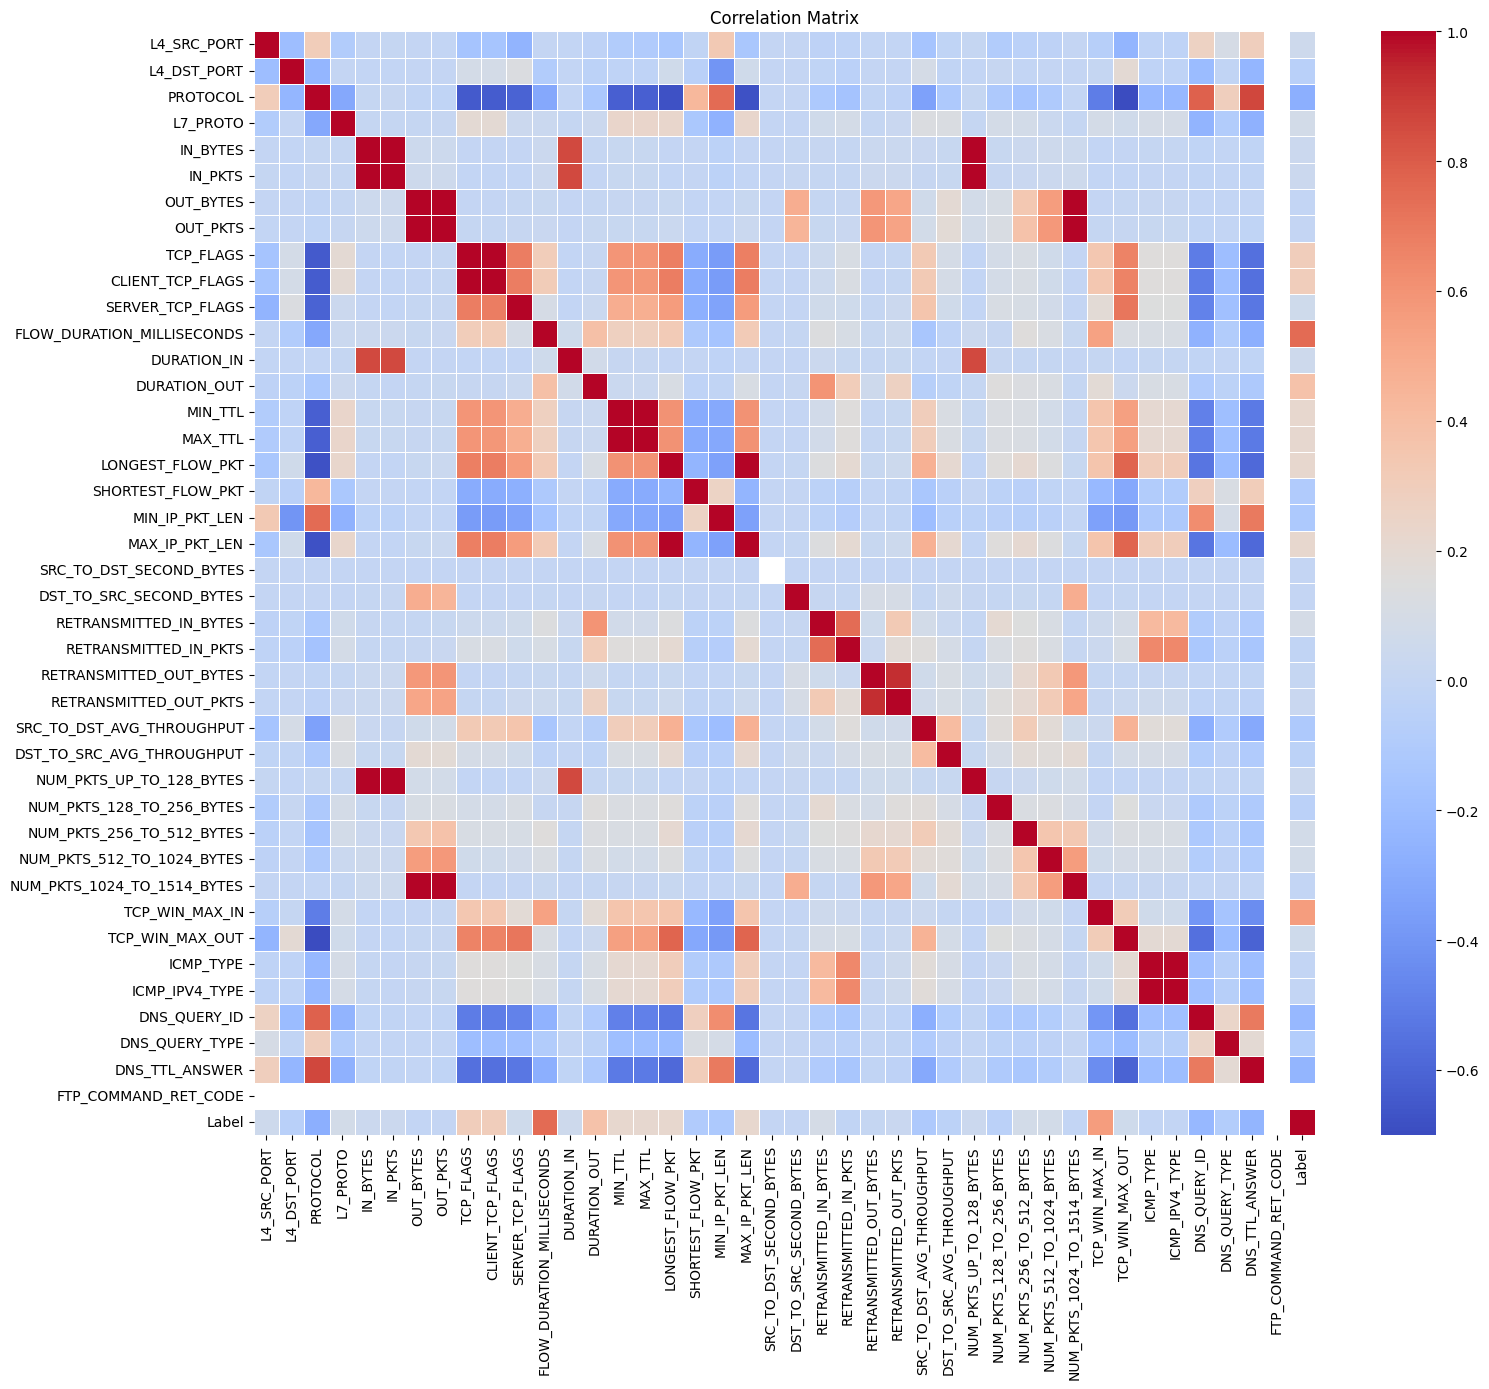

In [17]:
# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum().sum()}")

# Statistical summary of numeric features
print("\nNumeric features summary:")
print(df.describe())

# Distribution of features by attack category
plt.figure(figsize=(14, 8))
sns.boxplot(x='Attack_Category', y='FLOW_DURATION_MILLISECONDS', data=df)
plt.yscale('log')
plt.title('Flow Duration by Attack Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix for numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(16, 14))
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 3. Preprocessing


In [18]:
# Function to convert IP addresses to numeric values
def ip_to_int(ip_str):
    try:
        return int(ipaddress.IPv4Address(ip_str))
    except:
        return np.nan

# Convert IP addresses to numeric
df['IPV4_SRC_ADDR_INT'] = df['IPV4_SRC_ADDR'].apply(ip_to_int)
df['IPV4_DST_ADDR_INT'] = df['IPV4_DST_ADDR'].apply(ip_to_int)

# Drop original IP columns and any text columns not needed for modeling
columns_to_drop = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Attack_Category']
X = df.drop(columns=columns_to_drop + ['Label'], errors='ignore')

# Get labels
y = df['Label']

# Handle any remaining NaN values
X = X.fillna(0)

# Feature selection
selector = SelectKBest(f_classif, k=20)
X_selected = selector.fit_transform(X, y)
selected_features_idx = selector.get_support(indices=True)
selected_features = X.columns[selected_features_idx]
print("\nSelected features:", selected_features.tolist())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# For OneClassSVM, we need only normal data for training
X_train_normal = X_train[y_train == 0]


Selected features: ['PROTOCOL', 'L7_PROTO', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_IN_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT', 'NUM_PKTS_256_TO_512_BYTES', 'TCP_WIN_MAX_IN', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'DNS_TTL_ANSWER', 'IPV4_SRC_ADDR_INT']


# 4. Model Building (OneClassSVM)

In [19]:
# Train OneClassSVM on normal data only
print("\nTraining OneClassSVM...")
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
ocsvm.fit(X_train_normal)

# Predict on test data
# -1 for outliers (attacks), 1 for inliers (normal)
y_pred_test = ocsvm.predict(X_test)

# Convert predictions: -1 (anomaly) to 1 (attack), 1 (normal) to 0 (benign)
y_pred_binary = np.where(y_pred_test == -1, 1, 0)


Training OneClassSVM...


# 5. Model Evaluation



Model Performance:
Accuracy: 0.9415
Precision: 0.8932
Recall: 0.5802
F1 Score: 0.7035


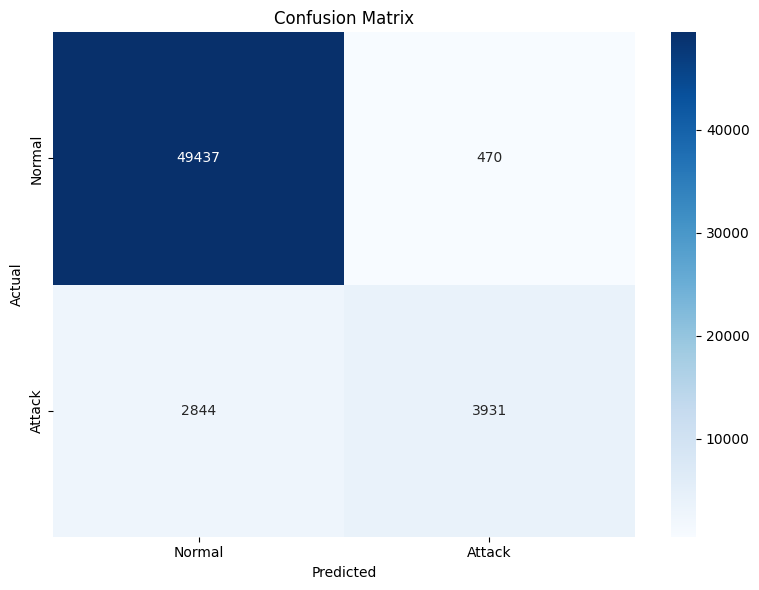


Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97     49907
      Attack       0.89      0.58      0.70      6775

    accuracy                           0.94     56682
   macro avg       0.92      0.79      0.84     56682
weighted avg       0.94      0.94      0.94     56682



In [20]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average='binary')

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Normal', 'Attack']))

# Feature importance analysis
if hasattr(ocsvm, 'coef_'):
    feature_importance = np.abs(ocsvm.coef_[0])
    feature_names = selected_features.tolist()

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title('Feature Importance (OneClassSVM)')
    plt.tight_layout()
    plt.show()

# 6. Hyperparameter Tuning

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define a custom scoring function for OneClassSVM
def custom_score(estimator, X):
    pred = estimator.predict(X)
    pred_binary = np.where(pred == -1, 1, 0)
    # Assuming y_test_for_tuning is defined
    return f1_score(y_test_for_tuning, pred_binary)

# Create a small subset for tuning to save time
X_tune, X_holdout, y_tune, y_holdout = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)
X_test_for_tuning, y_test_for_tuning = X_tune, y_tune

# Define parameter grid
param_grid = {
    'nu': [0.01, 0.05, 0.1],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

# Set up GridSearchCV with custom scorer
grid_search = GridSearchCV(
    OneClassSVM(),
    param_grid=param_grid,
    scoring=make_scorer(custom_score, greater_is_better=True),
    cv=3,
    verbose=1
)

# Train on normal data only
X_tune_normal = X_tune[y_tune == 0]
grid_search.fit(X_tune_normal, y_tune[y_tune == 0])

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Evaluate best model on holdout set
best_model = grid_search.best_estimator_
y_pred_holdout = best_model.predict(X_holdout)
y_pred_holdout_binary = np.where(y_pred_holdout == -1, 1, 0)

print("\nBest Model Performance on Holdout Set:")
print(classification_report(y_holdout, y_pred_holdout_binary, target_names=['Normal', 'Attack']))

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best score: nan

Best Model Performance on Holdout Set:
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97     24954
      Attack       0.88      0.64      0.74      3387

    accuracy                           0.95     28341
   macro avg       0.92      0.81      0.86     28341
weighted avg       0.94      0.95      0.94     28341

